In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 


import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy.spatial import distance
from sklearn.metrics.pairwise import nan_euclidean_distances

from matplotlib.lines import Line2D
from matplotlib import rcParams, cycler
from sklearn.preprocessing import PowerTransformer

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [7]:
def initialize(threshold, start_time):
    PM25 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/PM25")

    times = pd.date_range(start=start_time, end='2018-12-31 23:00:00', freq='30Min') #one less because the last is always nan

    start_idx = PM25.shape[0]-times.shape[0]

    # remove the last index as it is always nan
    PM25 = PM25[:-1]
    times = times[:-1]

    # reduced PM25 
    r_PM25 = PM25[start_idx:] 
    idx = r_PM25.notnull().sum(axis = 0)/r_PM25.shape[0]>threshold
    r_PM25 = r_PM25.loc[:, idx]

    r_PM25.reset_index(inplace=True)
    r_PM25.drop(labels = 'index',axis=1, inplace=True)
    
    return times, r_PM25



In [8]:
threshold = 0.6 # how much non-missing values are in the time-series in order to include the station?
start_time = '2013-01-01 00:00:00'
times, r_PM25 = initialize(threshold, start_time)

In [9]:
# keep the division of the CV identical to compare different algorithms. 
rnd_state_forCV = 0

In [80]:
def return_X_y_KFold_cross_validation(PM25,k, cv_num):
   
    kf = KFold(n_splits=k, random_state=rnd_state_forCV, shuffle=True)
    not_nan_idx = np.argwhere(PM25.notnull().values)
    results = []
    
    for i, (train_index, test_index) in enumerate(kf.split(not_nan_idx)):
        if i==cv_num:
            np_PM25 = PM25.values
            X_missing = PM25.copy()
            y_missing = PM25.copy()

            # y_missing 
            y_missing.iloc[:] = np.nan
            np_y_missing = y_missing.values

            # asssign values according to test indexes
            rows, cols = zip(*not_nan_idx[test_index])
            vals = np_PM25[rows, cols]
            np_y_missing[rows, cols] = vals
            # turn back to dataframe
            y_missing = pd.DataFrame(np_y_missing,columns=PM25.columns)

            # X_missing
            # assign nans according to test indexes
            np_X_missing = X_missing.values
            np_X_missing[rows, cols] = np.nan
        
    return np_X_missing, np_y_missing

In [11]:
r_PM25_copy = r_PM25.copy()
# np_r_PM25 = r_PM25_copy.values
# np_r_PM25.shape
np_r_PM25, np_r_PM25_y = return_X_y_KFold_cross_validation(r_PM25_copy,10)

### compare cv

In [ ]:
# without days 
results_woD_BR = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_BR")
results_woD_RF = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_RF")
results_woD_KNN = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/results_woD_KNN")

In [76]:
my_KNN_cv1 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv1")
my_KNN_cv2 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv2")
my_KNN_cv3 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv3")
my_KNN_cv4 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv4")
my_KNN_cv5 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv5")
my_KNN_cv6 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv6")
my_KNN_cv7 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv7")
my_KNN_cv8 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv8")
my_KNN_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv10")

In [ ]:
# my_KNN all cross-validations

def return_results_my_knn(np_values, np_r_PM25_y):
    y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y)]
    y_pred = np_values[~np.isnan(np_r_PM25_y)]

    RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
    MedianAE = median_absolute_error(y_train, y_pred)
    MeanAE = mean_absolute_error(y_train,y_pred)
    R2 = r2_score(y_train,y_pred)

    return [RMSE,MedianAE,MeanAE,R2]

 
results_my_KNN = results_woD_KNN.copy() 
for i in (1,2,3,4,5,6,7,8,10):
    r_PM25_copy = r_PM25.copy()
    np_r_PM25, np_r_PM25_y = return_X_y_KFold_cross_validation(r_PM25_copy,10,i-1)
    my_KNN_file = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv"+str(i))
    np_values = my_KNN_file.values
    results_my_KNN.iloc[i-1,:] = (return_results_my_knn(np_values, np_r_PM25_y))
    
results_my_KNN.iloc[8,:]=[np.nan,np.nan,np.nan,np.nan]

In [92]:
results_my_KNN

,RMSE,MedianAE,MeanAE,R2
0,8.672775,3.714441,5.282305,0.860843
1,8.989235,3.712012,5.302493,0.851181
2,8.946259,3.733365,5.309578,0.855717
3,9.169070,3.716230,5.278854,0.849114
4,8.929996,3.715543,5.296726,0.857600
5,8.587551,3.705423,5.266535,0.856665
6,8.829144,3.721148,5.300121,0.844840
7,8.802232,3.718336,5.293494,0.864461
8,NaN,NaN,NaN,NaN
9,8.759439,3.698848,5.269229,0.857484


In [93]:
# addition-1 dbda
RF_woD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_dbda_cv10")
my_KNN_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_dbda_cv10")

In [94]:
# addition-2
RF_wD_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_wD_cv10")

In [95]:
# addition-1+2
RF_wD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_wD_dbda_cv10")

In [96]:
def return_results_per_cv(np_values, np_r_PM25_y):
    y_train = np_r_PM25_y[~np.isnan(np_r_PM25_y)]
    y_pred = np_values[~np.isnan(np_r_PM25_y)]

    RMSE = np.sqrt(mean_squared_error(y_train, y_pred))
    MedianAE = median_absolute_error(y_train, y_pred)
    MeanAE = mean_absolute_error(y_train,y_pred)
    R2 = r2_score(y_train,y_pred)

    results_CV = results_woD_KNN.copy() 

    results_CV.iloc[9,:] = [RMSE,MedianAE,MeanAE,R2]
    for i in range(9):
        results_CV.iloc[i,:] = [np.nan,np.nan,np.nan,np.nan]
    return results_CV

    

In [97]:
# # my_KNN_cv10
# np_values = my_KNN_cv10.values
# results_woD_My_KNN_CV10 = return_results_per_cv(np_values, np_r_PM25_y)

In [98]:
# RF_woD_dbda_cv10 
np_values = RF_woD_dbda_cv10.values
results_RF_woD_dbda_cv10 = return_results_per_cv(np_values, np_r_PM25_y)

In [99]:
# my_KNN_dbda_cv10
np_values = my_KNN_dbda_cv10.values
results_my_KNN_dbda_cv10 = return_results_per_cv(np_values, np_r_PM25_y) 

In [100]:
# RF_wD_cv10
np_values = RF_wD_cv10.values
results_RF_wD_cv10 = return_results_per_cv(np_values, np_r_PM25_y) 

In [101]:
# RF_wD_dbda_cv10
np_values = RF_wD_dbda_cv10.values
results_RF_wD_dbda_cv10 = return_results_per_cv(np_values, np_r_PM25_y)

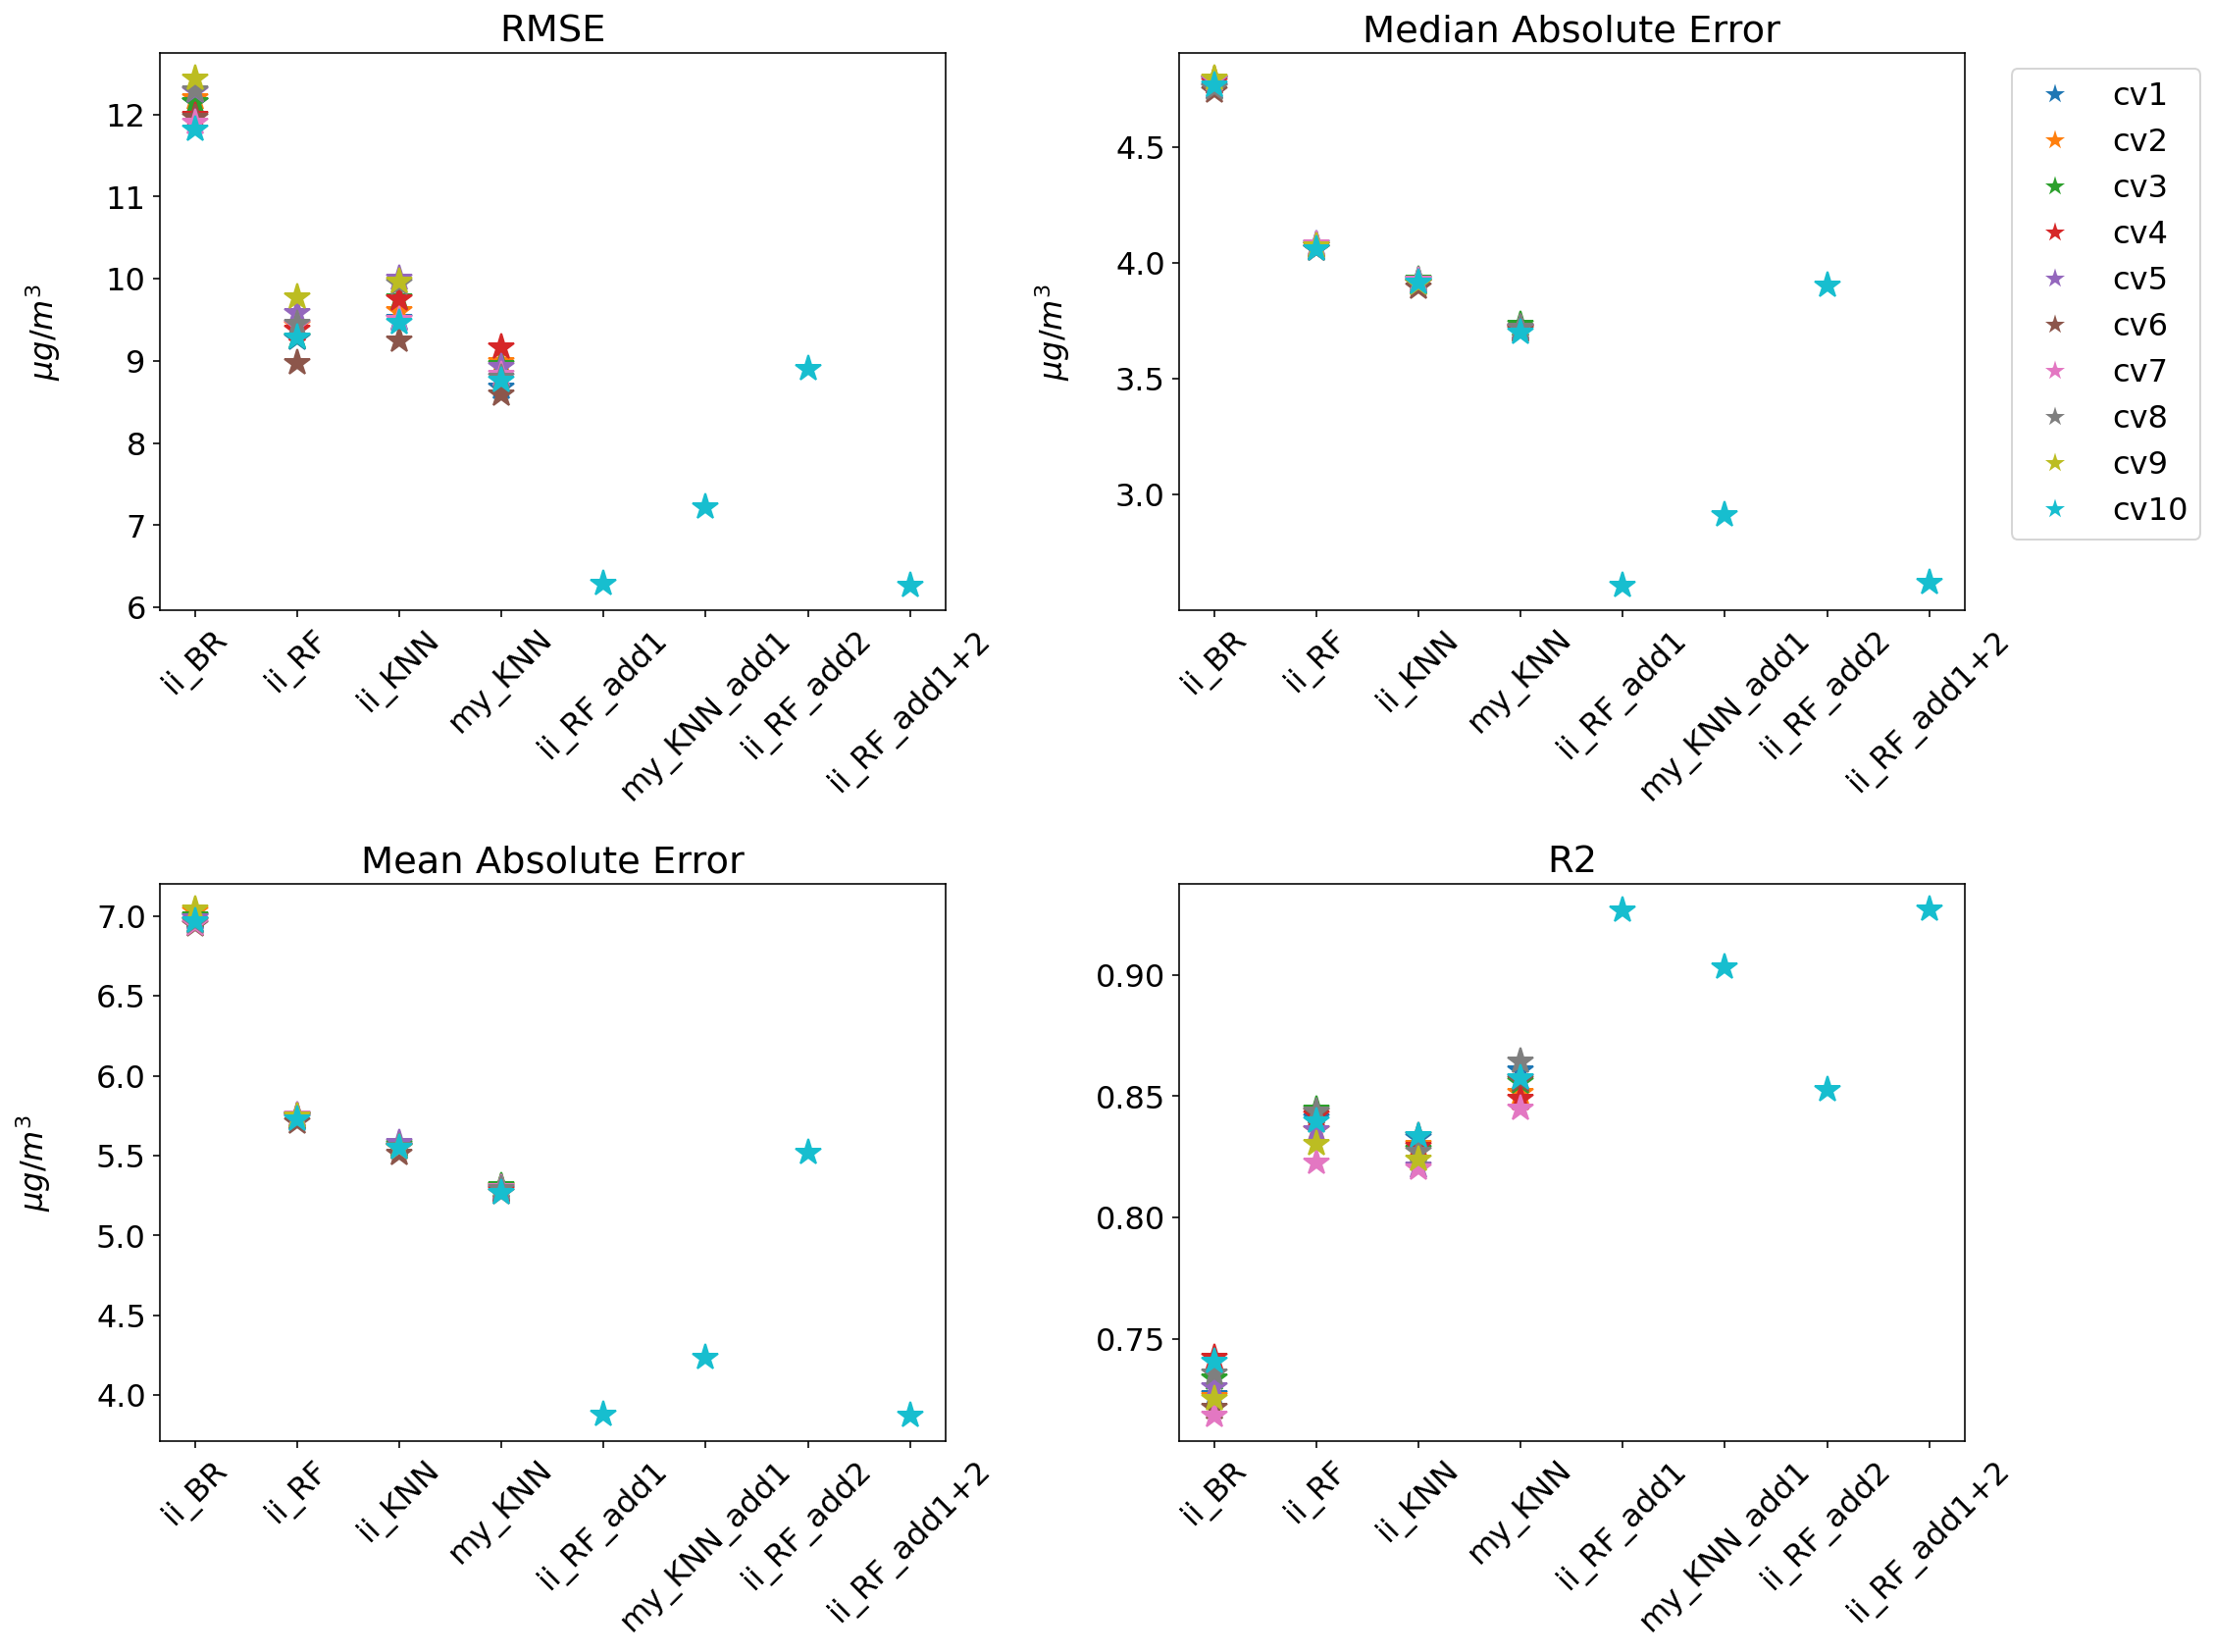

In [109]:
titles = ['RMSE','Median Absolute Error','Mean Absolute Error','R2']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,12))
# fig.suptitle('Cross-validation results')

N=10
cmap = plt.cm.tab10
col = cmap(np.linspace(0, 1, N))
rcParams['axes.prop_cycle'] = cycler(color=col)


# ax1.plot(np.arange(0,4), [results_woD_BR.iloc[:,0],results_woD_RF.iloc[:,0],results_woD_KNN.iloc[:,0],results_my_KNN.iloc[:,0]],'*') #RMSE
# ax2.plot(np.arange(0,4), [results_woD_BR.iloc[:,1],results_woD_RF.iloc[:,1],results_woD_KNN.iloc[:,1],results_my_KNN.iloc[:,1]],'*') # Median Absolute Error
# ax3.plot(np.arange(0,4), [results_woD_BR.iloc[:,2],results_woD_RF.iloc[:,2],results_woD_KNN.iloc[:,2],results_my_KNN.iloc[:,2]],'*') # Mean Absolute Error
# ax4.plot(np.arange(0,4), [results_woD_BR.iloc[:,3],results_woD_RF.iloc[:,3],results_woD_KNN.iloc[:,3],results_my_KNN.iloc[:,3]],'*') #r2


ax1.plot(np.arange(0,8), [results_woD_BR.iloc[:,0],results_woD_RF.iloc[:,0],results_woD_KNN.iloc[:,0],results_my_KNN.iloc[:,0], results_RF_woD_dbda_cv10.iloc[:,0], results_my_KNN_dbda_cv10.iloc[:,0], results_RF_wD_cv10.iloc[:,0],results_RF_wD_dbda_cv10.iloc[:,0]],'*') #RMSE
ax2.plot(np.arange(0,8), [results_woD_BR.iloc[:,1],results_woD_RF.iloc[:,1],results_woD_KNN.iloc[:,1],results_my_KNN.iloc[:,1], results_RF_woD_dbda_cv10.iloc[:,1], results_my_KNN_dbda_cv10.iloc[:,1], results_RF_wD_cv10.iloc[:,1],results_RF_wD_dbda_cv10.iloc[:,1]],'*') # Median Absolute Error
ax3.plot(np.arange(0,8), [results_woD_BR.iloc[:,2],results_woD_RF.iloc[:,2],results_woD_KNN.iloc[:,2],results_my_KNN.iloc[:,2], results_RF_woD_dbda_cv10.iloc[:,2], results_my_KNN_dbda_cv10.iloc[:,2], results_RF_wD_cv10.iloc[:,2],results_RF_wD_dbda_cv10.iloc[:,2]],'*') # Mean Absolute Error
ax4.plot(np.arange(0,8), [results_woD_BR.iloc[:,3],results_woD_RF.iloc[:,3],results_woD_KNN.iloc[:,3],results_my_KNN.iloc[:,3], results_RF_woD_dbda_cv10.iloc[:,3], results_my_KNN_dbda_cv10.iloc[:,3], results_RF_wD_cv10.iloc[:,3],results_RF_wD_dbda_cv10.iloc[:,3]],'*') #r2

legend_elements = [Line2D([0], [0], marker='*', color='w', label='cv1',
                          markerfacecolor=col[0], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv2',
                          markerfacecolor=col[1], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv3',
                          markerfacecolor=col[2], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv4',
                          markerfacecolor=col[3], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv5',
                          markerfacecolor=col[4], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv6',
                          markerfacecolor=col[5], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv7',
                          markerfacecolor=col[6], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv8',
                          markerfacecolor=col[7], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv9',
                          markerfacecolor=col[8], markersize=14),
                   Line2D([0], [0], marker='*', color='w', label='cv10',
                          markerfacecolor=col[9], markersize=14)]

for i,ax in enumerate(fig.get_axes()):
    ax.set_title(titles[i])   
#     ax.set_xticks(np.arange(0,4))
    ax.set_xticks(np.arange(0,8))

#     ax.set_xticklabels(['ii_BR','ii_RF','ii_KNN','my_KNN'],rotation=45)
    ax.set_xticklabels(['ii_BR','ii_RF','ii_KNN','my_KNN','ii_RF_add1','my_KNN_add1','ii_RF_add2','ii_RF_add1+2'],rotation=45)
    if i!=3:
        ax.set_ylabel('$\mu g/m^3$\n')
    if i==1:
        ax.legend(handles=legend_elements,bbox_to_anchor=(1.32,1))
    
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.markersize': 14})

plt.tight_layout()
# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/CV_results_basic.png", dpi=500)
# plt.savefig("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/CV_results_all.png", dpi=500)
plt.show();

In [40]:
# results_woD_BR
# results_woD_RF
# results_woD_KNN 
# results_woD_My_KNN_CV10

# results_RF_woD_dbda_cv10
# results_my_KNN_dbda_cv10
# results_RF_wD_dbda_cv10

### compare the time series (CV-10)

In [45]:
BR_woD_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/BR_woD_cv10")
RF_woD_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_cv10")
KNN_woD_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/KNN_woD_cv10")
my_KNN_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_cv11_from_before")

# addition-1
RF_woD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_woD_dbda_cv10")
my_KNN_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/my_KNN_dbda_cv10")

# addition-2
RF_wD_dbda_cv10 = pd.read_pickle("/Users/iditbela/Documents/Broday/saved_data_from_notebooks/RF_wD_dbda_cv10")

In [46]:
data_df = pd.concat([BR_woD_cv10, RF_woD_cv10, KNN_woD_cv10, my_KNN_cv10,RF_woD_dbda_cv10,my_KNN_dbda_cv10,RF_wD_dbda_cv10], keys=['BR', 'RF','KNN','my_KNN','RF_add1','my_KNN_add1','RF_add1+2'])

In [47]:
imputation_methods = ['BR', 'RF','KNN','my_KNN','RF_add1','my_KNN_add1','RF_add1+2']
len(imputation_methods)

7

In [48]:
# set extra colors in case more pollutants are measured in a station:
colors = ['#BC8F8F','blue','fuchsia','#BC8F8F','#8B4513','#2ca02c','#8B008B','#ff7f0e','#FFD700','LightSkyBlue']

color_lines = dict()
for im, c in zip(imputation_methods, colors[0:len(imputation_methods)+1]):
    color_lines[im] = c

In [50]:
def get_opposite_np_r_PM25_y():
    # generate np_r_PM25_y and modify it 
    r_PM25_copy = r_PM25.copy()
    np_r_PM25, np_r_PM25_y = return_X_y_KFold_cross_validation(r_PM25_copy,10)
    original_np_r_PM25_y = np_r_PM25_y.copy()
    np_r_PM25_y[np.isnan(np_r_PM25_y)] = -1
    np_r_PM25_y[np_r_PM25_y != -1 ] = np.nan
    return np_r_PM25_y, original_np_r_PM25_y
       

def get_missing_values_idx(missing_PM, Stations):
        
    missing_PM[missing_PM.notnull()] = 1
    missing_PM[missing_PM.isnull()] = 0
    diffs = missing_PM.diff(axis = 0)    
    #begining
    if missing_PM[Stations].iloc[0]==0:
        diffs[Stations].iloc[0]=-1

    #end
    if missing_PM[Stations].iloc[-1]==0:
        diffs[Stations].iloc[-1]=1

    row_start = np.where(diffs.loc[:,Stations] == -1)[0]
    row_end = np.where(diffs.loc[:,Stations] == 1)[0]

#     xranges = list(list(zip(row_start,row_end-row_start)))

    return row_start,row_end


def get_index(row_start, row_end):
    idx_x = np.array([])
    idx_y = np.array([])
    for rs,re in zip(row_start, row_end):  

        to_append_x = np.append(rs,np.append(np.arange(rs,re+1),re))
        idx_x=np.append(idx_x,to_append_x)

        to_append_y = np.append(0,np.append(np.ones((len(to_append_x)-2,))*1000,0))
        idx_y = np.append(idx_y,to_append_y)
    
    return idx_x.astype(int),idx_y    
    

In [75]:
# layout = go.Layout(
#     width = 700,
#     height = 400,
#     title={
#         'text': "CV-10 results",
#         'y':0.9,
#         'x':0.5,
#         'xanchor': 'right',
#         'yanchor': 'top'},
#     yaxis = dict(
#         title = '$\mu g/m^3$ '
#     ),
#     xaxis = dict(
#         title = 'Date'
#     ),
#     plot_bgcolor='rgb(255,255,250)'
# #     paper_bgcolor = 'rgba(0,0,0,0)',
# #     plot_bgcolor = 'rgba(0,0,0,0)'
# )

# def update_plot(Method,Stations):   

# #     data = [] #empty list where all my traces are in
#     fig = go.Figure(layout=layout)
        
#     # imputed
#     missing_PM = r_PM25.copy()
#     row_start,row_end = get_missing_values_idx(missing_PM, Stations)
#     idx_x, idx_y = get_index(row_start,row_end)
    
#     fig.add_trace(go.Scattergl(
#     x=times[idx_x],
#     y=idx_y,
#     mode = 'none',
#     name = 'imputed',
#     fillcolor='rgba(250,128,114, 0.5)',# the last value is opacity
#     fill='tozeroy')) # fill down to xaxis
    
# #     # validated
#     np_r_PM25_y, original_np_r_PM25_y = get_opposite_np_r_PM25_y()
#     r_PM25_y = pd.DataFrame(np_r_PM25_y,columns=r_PM25.columns)

#     row_start,row_end = get_missing_values_idx(r_PM25_y, Stations)
#     idx_x, idx_y = get_index(row_start,row_end)
    
#     fig.add_trace(go.Scattergl(
#     x=times[idx_x],
#     y=idx_y,
#     mode = 'none',
#     name = 'validated',
#     fillcolor='rgba(0,255,127, 0.5)',# the last value is opacity
#     fill='tozeroy')) # fill down to xaxis
    
#     # validated values 
#     original_r_PM25_y = pd.DataFrame(original_np_r_PM25_y,columns=r_PM25.columns)
#     d = original_r_PM25_y.loc[:,Stations]
     
#     fig.add_trace(go.Scattergl(
#     x=times,
#     y=d,
#     mode = 'markers',
#     name = 'validation point',
#     marker = dict(size=5,color='#FF0000')
#     )) # fill down to xaxis


    
#     for m in Method: # signals are the items in the multiselect widget    

#         chosen_data = data_df.loc[m][Stations]
        
#         # updaing imputation method
#         fig.add_trace(go.Scattergl(
#             x=times,
#             y=chosen_data,
#             mode = 'lines+markers',#lines/markers
#             name = '{}\n{}'.format(m,Stations),
#             opacity=.8,
#             line = dict(width=0.5,color=color_lines[m]),
#             marker = dict(size=4,color=color_lines[m]),
#             showlegend = True
#         ))

#     # if large data:
#     pio.write_html(fig, file='index.html', auto_open=True)
#     # when using notebook
#     py.offline.iplot(fig)
# #     # if small data:
# #     cpy.plot(fig, filename = 'cv_compare', auto_open=True)

# i = widgets.interact(update_plot, 
#              Stations = widgets.Dropdown(options=list(RF_woD_cv10.columns),description='Station'),
#              Method = widgets.SelectMultiple(options=imputation_methods,value=('RF','my_KNN','RF_add1','my_KNN_add1'))
#              )

In [72]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as cpy
import plotly.io as pio

In [73]:
username = 'iditbela' # your username
api_key = 'znw1tfcxvG5gRUmiFjjq' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [ ]:
# cpy.plot(fig, filename = 'cv_compare', auto_open=True)

In [ ]:
# show results per station
# show results as a function of percent of missing data - is there a relation?
# validate per length of missing validation interval